In [66]:
import numpy as np
import utils
import  matplotlib.pyplot as plt
import optimization
class Logistic(object):
    def __init__(self,fit_intercept=True,solver='sgd',if_standard=True,l1_ratio=None,l2_ratio=None,epochs=10,
               eta=None,batch_size=16):
        self.w=None
        self.fit_intercept=fit_intercept
        self.if_standard = if_standard
        self.solver = solver
        if if_standard:
            self.feature_mean=None
            self.feature_std=None
        self.epochs=epochs
        self.eta=eta
        self.batch_size = batch_size
        self.l1_ratio = l1_ratio
        self.l2_ratio = l2_ratio
        self.sign_func = np.vectorize(utils.sign)
        self.losses = []
        
    def init_param(self,n_features):
        self.w = np.random.random((n_features,1))
    
    def _fit(self,X,Y):
        X_Y = np.c_[X,Y]
        count = 0
        for _ in range(self.epochs):
            np.random.shuffle(X_Y)
            for index in range(X_Y.shape[0] // self.batch_size):
                count+=1
                batch_X_Y = X_Y[self.batch_size * index:self.batch_size * (index + 1)]        
                batch_x = batch_X_Y[:,:-1]
                batch_y = batch_X_Y[:,-1:]
                dw = -1 * batch_x.T @ (batch_y - utils.sigmoid(batch_x @ self.w)) / self.batch_size
                # 只对系数进行正则化
                dw_reg = np.zeros(shape=(X.shape[1]-1,1))
                if self.l1_ratio is not None:
                    dw_reg += self.l1_ratio * self.sign_func(self.w[:-1]) / self.batch_size
                if self.l2_ratio is not None:
                    dw_reg += 2 * self.l2_ratio * self.w[:-1] / self.batch_size
                dw_reg = np.concatenate([dw_reg,np.asarray([[0]])],axis=0)
                
                dw += dw_reg
                if self.solver == 'dfp':
                    if self.dfp is None:
                        self.dfp = optimization.DFP(x0 = self.w,g0 = dw)
                    else:
                        self.dfp.update_quasi_newton_matrix(self.w,dw)
                    # 更新下降方向，从原来的梯度方向更新成牛顿方向的反方向
                    dw = self.dfp.adjust_gradient(dw)
                if self.solver == 'bfgs':
                    if self.bfgs is None:
                        self.bfgs = optimization.BFGS(self.w,dw)
                    else :
                        self.bfgs.update_quasi_newton_matrix(self.w,dw)
                    dw = self.bfgs.adjust_gradient(dw)
                
                self.w = self.w - self.eta * dw
                
            cost = -1 * (Y.T @ np.log(utils.sigmoid(X @ self.w)) + (1 - Y).T @  np.log(1 - utils.sigmoid(X @ self.w)) )[0][0]
            self.losses.append(cost)

    def fit(self,X,Y):
        # 将Y变成列向量
        Y = Y.reshape(X.shape[0],1)
        
        if self.if_standard:
            self.feature_mean = np.mean(X,axis=0)
            self.feature_std = np.std(X,axis=0)+1e-8
            X = (X - self.feature_mean) / self.feature_std
        # 将偏置项并入X中
        if self.fit_intercept:
            X = np.c_[X,np.ones_like(Y)]
        self.init_param(X.shape[1])
        # 设置默认的学习率
        if self.eta is None:
            self.eta = self.batch_size / np.sqrt(X.shape[0])
        if self.solver == 'bfgs':
            self.bfgs = None
        elif self.solver == 'dfp':
            self.dfp = None
        self._fit(X,Y)
        
    def get_params(self):
        if self.fit_intercept:
            w = self.w[:-1]
            b = self.w[-1]
        else:
            w = self.w
            b = 0
        if self.if_standard:
            w = w / self.feature_std.reshape(-1,1)
            b = b - (w / self.feature_std.reshape(-1,1)).T @ self.feature_mean.reshape(-1,1)
        return w.reshape(-1),b
    
    def predict_prob(self,X):
        # 计算y=1的概率
        if self.if_standard:
            X = (X - self.feature_mean) / self.feature_std
        if self.fit_intercept:
            X = np.c_[X,np.ones(shape=(X.shape[0],1))]
        return np.c_[1-utils.sigmoid(X @ self.w),utils.sigmoid(X @ self.w)]
    
    def predict(self,X):
        return np.argmax(self.predict_prob(X),axis=1)
    
    def plot_decision_boundry(self,X,Y):
        Y = Y.reshape(-1,1)
        weights ,bias = self.get_params()
        w1 = weights[0]
        w2 = weights[1]
        b = bias[0][0]
        x1 = np.arange(np.min(X),np.max(X),0.1)
        x2 = -w1 * x1 / w2 - b / w2
        plt.scatter(X[:,0],X[:,1],c=Y,s=50)
        plt.plot(x1,x2,'r')
        plt.show()
        
    def plot_loss(self):
        plt.plot(range(0,len(self.losses)),self.losses)
        plt.show()

In [67]:
import utils
import numpy as np
# 将处理一元的函数向量化
sign = np.vectorize(utils.sign)
print(sign([[1,2],[2,3],[3,4]]))
# 对每个元素都应用一下sigmoid函数
utils.sigmoid(np.array([[1,2],[2,3],[3,4]]))

[[1 1]
 [1 1]
 [1 1]]


array([[0.73105858, 0.88079708],
       [0.88079708, 0.95257413],
       [0.95257413, 0.98201379]])

In [68]:

X = np.array([[1,2],[3,4]])
print('min:',np.min(X))
w = np.array([[1],[2]])
Y = np.array([[1],[2]])
# 其中axis=0表示将第0维按照mean函数计算后压缩成一个标量，第二维保留
print('mean:',np.mean(X,axis=0))
cost = -1 * (Y.T.dot(np.log(utils.sigmoid(X.dot(w)))) + (1 - Y).T.dot( np.log(1 - utils.sigmoid(X.dot(w)))))
print(Y.T)
# 另一种方式的矩阵乘法，使用@符号相当于.dot进行矩阵乘法
print(np.log(utils.sigmoid(X @ w)))
print(Y.T.dot(np.log(utils.sigmoid(X.dot(w)))))
cost

min: 1
mean: [2. 3.]
[[1 2]]
[[-6.71534849e-03]
 [-1.67015613e-05]]
[[-0.00674875]]


array([[-10.99326795]])

In [69]:
w = np.array([[1],[2],[3]])
print(w[:-1])
# 使用这种方式的切片只保留第二个维度
print(w[-1])
# 使用下面这种方式的切片能够保持维数，比如w是两维度的，那结果还是保持两维
print(w[-1:])
print(np.array([1,2,3]).shape)

[[1]
 [2]]
[3]
[[3]]
(3,)


In [70]:
# 构造分类数据进行测试
from sklearn.datasets import make_classification
data,target = make_classification(n_samples=100,n_features=2,n_classes=2,n_informative=1,n_redundant=0,n_repeated=0,n_clusters_per_class=1)

In [71]:
data.shape,target.shape

((100, 2), (100,))

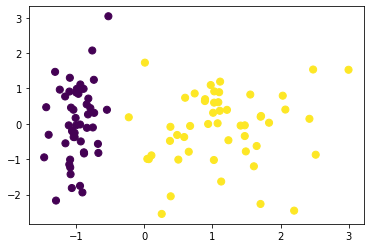

In [72]:
plt.scatter(data[:,0],data[:,1],c=target,s = 50)

In [73]:
lr = Logistic(l1_ratio=0.01,l2_ratio=0.01,solver='sgd')
lr.fit(data, target)
lr.get_params()

(array([ 3.99349544, -0.2539297 ]), array([[0.61699586]]))

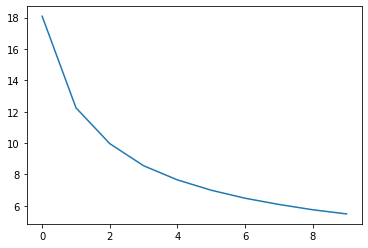

In [74]:
lr.plot_loss()

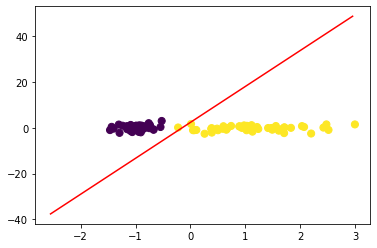

In [75]:
lr.plot_decision_boundry(data,target)

/Users/wenshuiluo/coding/Python/机器学习/learning/optimization.py:30: RuntimeWarning: invalid value encountered in true_divide
  self.G0 = self.G0 + delta0.dot(delta0.T) / delta0.T.dot(y0)[0][0] - self.G0.dot(y0).dot(y0.T).dot(self.G0) / \


[26900.00019636884, 26900.00019636884, 26900.00019636884, 26900.00019636884, 26900.00019636884, 26900.00019636884, 26900.00019636884, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


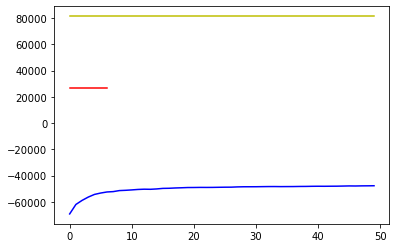

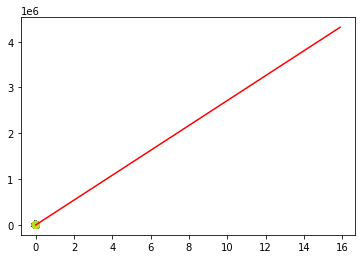

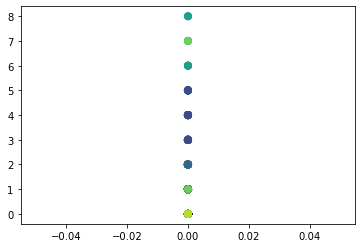

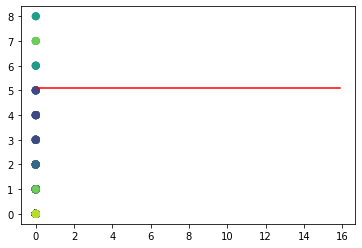

In [81]:
sgd_model = Logistic(epochs=50)
sgd_model.fit(data,target)

dfp_model = Logistic(epochs=50,solver='dfp')
dfp_model.fit(data,target)

bfgs_model = Logistic(solver='bfgs',epochs=50)
bfgs_model.fit(data,target)

plt.plot(range(len(sgd_model.losses)),sgd_model.losses,'b')
plt.plot(range(len(dfp_model.losses)),dfp_model.losses,'r')
plt.plot(range(len(bfgs_model.losses)),bfgs_model.losses,'y')
plt.figure()
sgd_model.plot_decision_boundry(data,target)
dfp_model.plot_decision_boundry(data,target)
bfgs_model.plot_decision_boundry(data,target)

In [77]:

import threading
import copy
class MyThread(threading.Thread):
    # target:run函数的回调函数，args和kwargs为target函数的参数
    # args:为解开的元组，kwargs：未解开的字典类型数据，使用* 或者是**符号解开，变成参数形式
    def __init__(self, target,args,kwargs,name=''):
        threading.Thread.__init__(self)
        self.target = target
        self.name = name
        self.args = args
        self.kwargs = kwargs
        self.result = self.target(*self.args,**self.kwargs)
        
    def get_result(self):
        try:
            return self.result
        except:
            return None   

class MultiClassWrapper(object):
    def __init__(self,base_classifier,mode='ovr'):
        super().__init__()
        self.base_classifier = base_classifier
        self.mode = mode
        
    @staticmethod
    def fit_base_classifier(base_classifier,X,Y,**kwargs):
        return base_classifier.fit(X,Y, **kwargs)
    
    @staticmethod
    def predict_proba_base_classifier(base_classifier,X):
        return base_classifier.predict_prob(X)
        
    def fit(self,X,Y,**kwargs):
        # 类别，从0-n_class一共有n_class+1个类别
        self.n_class = np.max(Y)
        if self.mode=='ovr':
            self.classifiers = []
            # 每个类别有一个生成器
            for cls in range(0,self.n_class+1):
                # 深度复制基础分类器
                self.classifiers.append(copy.deepcopy(self.base_classifier))
            # 进行并行计算
            tasks = []
            for cls in range(0,self.n_class + 1):
                task = MyThread(target=self.fit_base_classifier,
                                args=(self.classifiers[cls],X,(Y == cls).astype('int')),kwargs=kwargs)
                task.start()
                tasks.append(task)
            # 子线程执行时主线程进入阻塞状态等待所有线程执行完毕
            # 所有线程执行完之后主线程接着执行下面的代码
            # 进行线程同步
            for task in tasks:
                task.join()
        elif self.mode == 'ovo':
            self.classifiers = {}
            for first_cls in range(0,self.n_class):
                for second_cls in range(first_cls+1,self.n_class + 1):
                    self.classifiers[(first_cls,second_cls)]=copy.deepcopy(self.base_classifier)
            
            tasks = {}
            for first_cls in range(0,self.n_class):
                for second_cls in range(first_cls+1,self.n_class + 1):
                    # 取出这两个类别的样本进行训练
                    # 如果使用+的话，在numpy中只能是通过广播将array加起来，不能实现拼接，
                    # np.where返回的结果是一个元组，其中0，1...位置分别是索引的维度
                    index = np.where(np.logical_or(Y == first_cls ,Y == second_cls))[0]
                    new_X = X[index,:] 
                    new_Y = Y[index]
                    task = MyThread(target=self.fit_base_classifier,
                                    args=(self.classifiers[(first_cls,second_cls)],new_X,
                                          (new_Y == first_cls).astype('int')),kwargs=kwargs)
                    task.start()
                    tasks[(first_cls,second_cls)] = task
                    
            for first_cls in range(0,self.n_class):
                for second_cls in range(first_cls + 1,self.n_class + 1):
                    tasks[(first_cls,second_cls)].join()
            
    
    def predict_prob(self,X,**kwargs):
        if self.mode == 'ovr':
            tasks = []
            probas = []
            for cls in range(0,self.n_class + 1):
                task = MyThread(target=self.predict_proba_base_classifier,args=(self.classifiers[cls],X),
                                kwargs=kwargs)
                task.start()
                tasks.append(task)
            for task in tasks:
                task.join()
            for task in tasks:
                probas.append(task.get_result()[:,1])
            total_probs = np.asarray(probas).T
            # 计算归一化概率
            return total_probs / np.sum(total_probs,axis=1,keepdims=True)
        elif self.mode=='ovo':
            tasks = {}
            probas = {}
            for first_cls in range(0,self.n_class):
                for second_cls in range(first_cls+1,self.n_class + 1):
                    task = MyThread(target=self.predict_proba_base_classifier,args=(
                        self.classifiers[(first_cls,second_cls)],X),kwargs=kwargs)
                    task.start()
                    tasks[(first_cls,second_cls)] = task
            for first_cls in range(0,self.n_class):
                for second_cls in range(first_cls+1,self.n_class + 1):
                    tasks[(first_cls,second_cls)].join()
            
            for first_cls in range(0,self.n_class):
                for second_cls in range(first_cls+1,self.n_class + 1):
                    probas[(first_cls,second_cls)] = tasks[(first_cls,second_cls)].get_result()
                    probas[(second_cls,first_cls)] = 1.0 - probas[(first_cls,second_cls)]
                
            total_probas = []
            for first_cls in range(0,self.n_class + 1):
                temp = []
                for second_cls in range(0,self.n_class + 1):
                    if first_cls != second_cls:
                        temp.append(probas[(first_cls,second_cls)])
                # 对于每个类别，求出N个样本分别被预测为1的非规范化概率
                temp = np.sum(temp,axis=0)[:,1]
                total_probas.append(temp)
            # 对概率进行归一化
            total_probas = np.asarray(total_probas).T
            return total_probas / total_probas.sum(axis=1,keepdims=True)

    
    def predict(self,X):
        return np.argmax(self.predict_prob(X),axis=1)

In [78]:
#准备手写数据
from sklearn.metrics import f1_score
from sklearn import model_selection
from sklearn import datasets
digits = datasets.load_digits()
data = digits['data']
target = digits['target']
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, target, test_size=0.3,
                                                                    random_state=0)
print(X_train.shape,y_train.shape)
lr = Logistic()
#进行one-vs-rest训练并评估
ovr = MultiClassWrapper(lr, mode='ovr')
ovr.fit(X_train, y_train)

y = ovr.predict(X_test)
print('ovr:', f1_score(y_test, y, average='macro'))

ovo = MultiClassWrapper(Logistic(), mode='ovo')
ovo.fit(X_train, y_train)

y = ovo.predict(X_test)
print('ovo:', f1_score(y_test, y, average='macro'))

(1257, 64) (1257,)
ovr: 0.9437761393632675
ovo: 0.9542964569865452


In [79]:

a = [np.arange(6).reshape(3,2),np.arange(6,12).reshape(3,2),np.arange(12,18).reshape(3,2)]
a = np.asarray(a)
print(a)
print(np.concatenate(a,axis = 1))
print(np.sum(a,axis=0))
print(np.sum(a,axis=0)[:,1])

[[[ 0  1]
  [ 2  3]
  [ 4  5]]

 [[ 6  7]
  [ 8  9]
  [10 11]]

 [[12 13]
  [14 15]
  [16 17]]]
[[ 0  1  6  7 12 13]
 [ 2  3  8  9 14 15]
 [ 4  5 10 11 16 17]]
[[18 21]
 [24 27]
 [30 33]]
[21 27 33]


In [80]:
a = np.arange(6).reshape(3,2)
print(np.where(a > 3))
# 返回的元组每维分别是每个维度的索引值

(array([2, 2]), array([0, 1]))
